<a href="https://colab.research.google.com/github/Jagabathula-Projects/news-based-forecasting/blob/main/foodprice_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdate
import datetime as dt
from statsmodels.tsa.api import SARIMAX
import gensim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from IPython import embed
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.api import OLS
from datetime import datetime, timedelta
from collections import defaultdict
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge, LassoLars, Lars
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
import datetime as dt
from tensorflow.keras.layers.experimental.preprocessing import Normalization

# Reading the raw daily price data in Rs/quintal

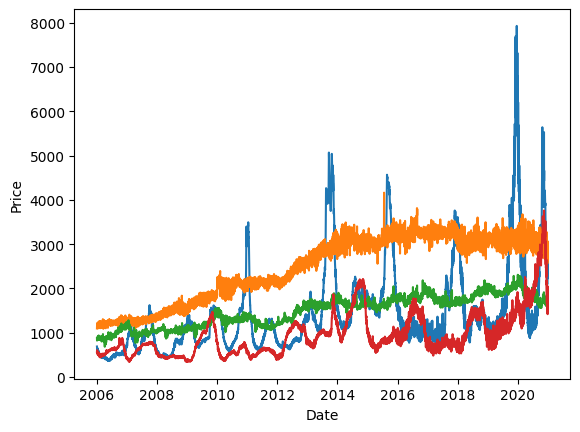

In [ ]:
path = '/content/drive/MyDrive/news-based-forecasting/price_data/'
df_o = pd.read_csv(f'{path}Onion.csv', parse_dates = ['date'], index_col = ['date'])
df_o.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_o)

df_r = pd.read_csv(f'{path}Rice.csv', parse_dates = ['date'], index_col = ['date'])
df_r.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_r)

df_w = pd.read_csv(f'{path}Wheat.csv', parse_dates = ['date'], index_col = ['date'])
df_w.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_w)

df_p = pd.read_csv(f'{path}Potato.csv', parse_dates = ['date'], index_col = ['date'])
df_r.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_p)

dates =  pd.read_csv(f'{path}Onion.csv')['date']

#### Define constants

In [ ]:
train_period_start = np.datetime64('2006-01-01') # Jan 1, 2013
train_period_end = np.datetime64('2012-12-31')
num_train_days = 2557 # till end of 2015
p=1
d=1
q=0
# forecast horizon
n_step_ahead = 1
kgs_in_quintal = 100
test_period_start = np.datetime64('2013-01-01')
test_period_end = np.datetime64('2020-12-31')
# test_period_end = num_train_days + 366 + 365 # 2016 and 2017
crop_prices_dict = {'Onion': df_o, 'Potato': df_p, 'Rice': df_r, 'Wheat': df_w}
jump_threshold = 0.05
linear_methods = ['arima', 'arima+LDA', 'arima+w2v', 'arima+events']
reg_alphas_ridge = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 25, 50, 75, 100, 125, 250, 300, 375, 400, 500, 750, 1e3, 5e3, 1e4]
reg_alphas = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
reg_alphas_log_return = [1e-4, 5e-4, 1e-3, 5e-3, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.5, 5.0]
fit_intercept = False
embed_multiplier = 1
color_list = ['r', 'b', 'g', 'k', 'y', 'm', 'c']
#event_lags = [1, 2, 3, 4, 5, 6, 7]
event_lags = [1, 7, 14, 21, 28]
price_lags = [1, 2, 3, 4, 5, 6, 7]

# Read different embeddings

In [ ]:
embeddings_path = '/content/drive/MyDrive/news-based-forecasting/embeddings/'
test_event_embeddings = np.load(f'{embeddings_path}events_test.npy')
train_event_embeddings = np.load(f'{embeddings_path}events_train.npy')
train_topic_embeddings = np.load(f'{embeddings_path}toi.avgLDA_train.npy')
test_topic_embeddings = np.load(f'{embeddings_path}toi.avgLDA_test.npy')
train_word_embeddings = np.load(f'{embeddings_path}toi.W2V_train.npy')
test_word_embeddings = np.load(f'{embeddings_path}toi.W2V_test.npy')
train_doc_embeddings = np.load(f'{embeddings_path}toi.D2V_train.npy')
test_doc_embeddings = np.load(f'{embeddings_path}toi.D2V_test.npy')
# concatenate train and test
all_event_embeddings = pd.DataFrame(np.vstack((train_event_embeddings, test_event_embeddings)), index=df_o.index)
all_word_embeddings = pd.DataFrame(np.vstack((train_word_embeddings, test_word_embeddings)), index=df_o.index)
all_topic_embeddings = pd.DataFrame(np.vstack((train_topic_embeddings, test_topic_embeddings)), index=df_o.index)
all_doc_embeddings = pd.DataFrame(np.vstack((train_doc_embeddings, test_doc_embeddings)), index=df_o.index)
all_embeddings_dict = {'LDA': all_topic_embeddings, 'w2v': all_word_embeddings, 'events': all_event_embeddings, 'd2v': all_doc_embeddings}

Verify embeddings

In [ ]:
all_doc_embeddings.min()

0     -2.972997
1     -2.970829
2     -2.995228
3     -2.984675
4     -2.984819
         ...   
245   -2.983415
246   -2.998954
247   -2.993553
248   -2.992228
249   -2.988399
Length: 250, dtype: float64

In [ ]:
np.unique(np.sum(all_topic_embeddings, 1)) # ideally should sum up to 1

array([  0.        ,   1.        ,   1.        , ..., 575.95821338,
       581.57988598, 588.39259261])

In [ ]:
all_topic_embeddings.max()

0.6023203134536743

In [ ]:
test_event_embeddings.shape, train_event_embeddings.shape, test_topic_embeddings.shape, train_topic_embeddings.shape, test_word_embeddings.shape, train_word_embeddings.shape

((2922, 250), (2557, 250), (2922, 250), (2557, 250), (2922, 250), (2557, 250))

In [ ]:
np.any(np.isnan(all_event_embeddings), axis=1).sum()

0

In [ ]:
np.sum(all_topic_embeddings, 1).max()

0.9890244013132078

# Forecasting using ARIMA models

In [ ]:
def computeRMSE(tr, pred):
    err = 0
    for i in range(len(tr)):
        err += (tr[i]-pred[i])**2
    return np.sqrt(err/len(tr))
# Also compute the MAPE

In [ ]:
def ARIMA_forecasts(price_df, crop):
  df_train = price_df.iloc[:num_train_days]
  model = ARIMA(df_train, order=(p,d,q))
  # SARIMAX with period 365 takes too long to run so using the procedure given in the link below
  # https://github.com/statsmodels/statsmodels/issues/5727#issuecomment-660742852
  # model_fit = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
  # model = SARIMAX(df_train, order=(p,d,q))
  # default is 50 iterations which throws not converged warning
  model_fit = model.fit(method_kwargs={'maxiter': 200})
  arima_params = model_fit.params
  # model_fit = model.fit(maxiter=200)
  true_prices = price_df.loc[train_period_end+1:test_period_end].values
  predictions = []
  # To make consistent with AutoReg implementation, report train RMSE ignoring first p+1 days
  # print(f"ARIMA{(p,d,q)} train RMSE for {crop} = {mean_squared_error(df_train.iloc[p+1:], model_fit.predict().iloc[p+1:], squared=False):.2f}")
  for t in np.arange(test_period_start, test_period_end+1):
  #for t in range(num_train_days, test_period_end - n_step_ahead + 1):
      # model = ARIMA(history, order=(p,d,q))
      # model_fit = model.fit()
      yhat = model_fit.forecast(steps=n_step_ahead).iloc[-1]
      predictions.append(yhat)
      model_fit = model_fit.extend(price_df.loc[[t]])
      # history.append(testset[t])

  print(f"ARIMA{(p,d,q)} test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  return arima_params
  #print(f"ARIMA{(p,d,q)} test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

def ARIMA_plus_x_forecasts(price_df, crop, train_exog_embeddings, test_exog_embeddings, embedding_type, arima_params):
  df_train = price_df.iloc[:num_train_days]
  model = ARIMA(df_train, exog=train_exog_embeddings, order=(p,d,q))
  # model = SARIMAX(df_train, order=(p,d,q))
  # default is 50 iterations which throws not converged warning
  # https://github.com/statsmodels/statsmodels/issues/5727#issuecomment-660742852
  # model_fit = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
  # model_fit = model.fit(maxiter=200)
  num_exog_features = train_exog_embeddings.shape[1]
  model_fit = model.fit(method_kwargs={'maxiter': 200}, start_params=np.append(np.zeros(num_exog_features), arima_params))
  true_prices = price_df.iloc[num_train_days+n_step_ahead-1:].values
  predictions = []
  print(f"ARIMA{(p,d,q)}+{embedding_type} train RMSE for {crop} = {mean_squared_error(df_train, model_fit.predict(), squared=False):.2f}")
  for t in range(num_train_days, len(price_df) - n_step_ahead + 1):
      new_events = test_exog_embeddings[t-num_train_days:t+n_step_ahead-num_train_days]
      # give the actual events, best possible performance
      yhat = model_fit.forecast(steps=n_step_ahead, exog=new_events).iloc[-1]
      # yhat = model_fit.forecast(steps=n_step_ahead, exog=np.repeat(new_events, n_step_ahead, axis=0)).iloc[-1]
      predictions.append(yhat)
      model_fit = model_fit.extend(price_df.iloc[t:t+1], exog=new_events[:1])

  print(f"ARIMA{(p,d,q)}+{embedding_type} test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  #print(f"ARIMA{(p,d,q)}+{embedding_type} test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

In [ ]:
crop_name = 'Rice'
df_crop = crop_prices_dict[crop_name]
arima_params = ARIMA_forecasts(df_crop, crop_name)
#ARIMA_plus_x_forecasts(df_crop, crop_name, train_event_embeddings, test_event_embeddings, 'events', arima_params)
#ARIMA_plus_x_forecasts(df_crop, crop_name, train_topic_embeddings, test_topic_embeddings, 'topics', arima_params)
#ARIMA_plus_x_forecasts(df_crop, crop_name, train_word_embeddings, test_word_embeddings, 'w2v', arima_params)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0) test RMSE for Rice = 161.43


# Forecasting using Autoregressive model

In [ ]:
def AutoReg_forecasts(price_df, crop):
  diff_prices = price_df.diff()
  # df_train = diff_prices.iloc[1:num_train_days] # ignore the first day
  df_train = diff_prices.loc[train_period_start+1:train_period_end]
  model = AutoReg(df_train, lags=p, trend='n')
  model_fit = model.fit()
  print(model_fit.params)
  true_prices_one_day_forecast = diff_prices.loc[test_period_start:test_period_end]
  true_prices_seven_day_forecast = diff_prices.loc[test_period_start+n_step_ahead-1:test_period_end]
  # jump_indicators = np.ravel(np.abs(true_prices_one_day_forecast.values)/price_df.loc[num_train_days-1:test_period_end-1].values >= jump_threshold)
  predictions = []
  # cannot predict for first p days so compute train RMSE starting at day p
  # print(f"ARIMA{(p,d,q)} train RMSE for {crop} = {mean_squared_error(df_train.iloc[p:], model_fit.predict().iloc[p:], squared=False):.2f}")
  train_RMSE = mean_squared_error(df_train.iloc[p:], model_fit.predict().iloc[p:], squared=False)
  for t in np.arange(test_period_start, test_period_end+1):
    yhat = model_fit.forecast(steps=n_step_ahead).values
    predictions.append(yhat)
    new_price = diff_prices.loc[[t]]
    new_price.index.freq = 'D'
    model_fit = model_fit.append(new_price)

  predictions = np.array(predictions)
  #print(f"ARIMA{(p,d,q)} one-day ahead test RMSE for {crop} = {mean_squared_error(true_prices_one_day_forecast, predictions[:, 0], squared=False):.2f}")
  test_RMSE_one_day = mean_squared_error(true_prices_one_day_forecast, predictions[:, 0], squared=False)
  test_RMSE_seven_day = mean_squared_error(true_prices_seven_day_forecast, predictions[:-n_step_ahead+1, -1], squared=False)
  return train_RMSE, test_RMSE_one_day, test_RMSE_seven_day
  #print(f"ARIMA{(p,d,q)} seven-day ahead test RMSE for {crop} = {mean_squared_error(true_prices_seven_day_forecast, predictions[:-n_step_ahead+1, -1], squared=False):.2f}")
  #print(f"AR-{p} with diff test shocks-RMSE for {crop} = {mean_squared_error(true_prices[jump_indicators], predictions[jump_indicators], squared=False):.2f}")

In [ ]:
def AutoReg_plus_x_forecasts(price_df, crop, exog_embeddings, embedding_type):
  diff_prices = price_df.diff()
  df_train = diff_prices.loc[train_period_start+1:train_period_end]
  model = AutoReg(df_train, lags=p, trend='n', exog=exog_embeddings.loc[train_period_start:train_period_end-1].values)
  # model = AutoReg(df_train, lags=p, trend='n', exog=train_exog_embeddings[1:])
  model_fit = model.fit()
  print(f"For {embedding_type} AutoReg params {model_fit.params.iloc[:p]}")
  true_prices_one_day_forecast = diff_prices.loc[test_period_start:test_period_end]
  true_prices_seven_day_forecast = diff_prices.loc[test_period_start+n_step_ahead-1:test_period_end]
  # true_prices = diff_prices.iloc[num_train_days+n_step_ahead-1:test_period_end]
  # jump_indicators = np.ravel(np.abs(true_prices.values)/price_df.iloc[num_train_days-1:test_period_end-1].values >= jump_threshold)
  predictions = []
  # cannot predict for first p days so compute train RMSE starting at day p
  # print(f"ARIMA{(p,d,q)}+{embedding_type} train RMSE for {crop} = {mean_squared_error(df_train.iloc[p:], model_fit.predict().iloc[p:], squared=False):.2f}")
  train_RMSE = mean_squared_error(df_train.iloc[p:], model_fit.predict().iloc[p:], squared=False)
  for t in np.arange(test_period_start, test_period_end+1):
    new_events = exog_embeddings.loc[t-1:t+n_step_ahead-1]
    yhat = model_fit.forecast(steps=n_step_ahead, exog=new_events).values
    predictions.append(yhat)
    new_price = diff_prices.loc[[t]]
    new_price.index.freq = 'D'
    model_fit = model_fit.append(new_price, exog=new_events.iloc[:1])

  predictions = np.array(predictions)
  test_RMSE_one_day = mean_squared_error(true_prices_one_day_forecast, predictions[:, 0], squared=False)
  test_RMSE_seven_day = mean_squared_error(true_prices_seven_day_forecast, predictions[:-n_step_ahead+1, -1], squared=False)
  return train_RMSE, test_RMSE_one_day, test_RMSE_seven_day
  #print(f"ARIMA{(p,d,q)}+{embedding_type} one-day ahead test RMSE for {crop} = {mean_squared_error(true_prices_one_day_forecast, predictions[:, 0], squared=False):.2f}")
  #print(f"ARIMA{(p,d,q)}+{embedding_type} seven-day ahead test RMSE for {crop} = {mean_squared_error(true_prices_seven_day_forecast, predictions[:-n_step_ahead+1, -1], squared=False):.2f}")
  #print(f"AR-{p}+{embedding_type} with diff test shocks-RMSE for {crop} = {mean_squared_error(true_prices[jump_indicators], predictions[jump_indicators], squared=False):.2f}")

In [ ]:
one_day_ahead_forecasts = defaultdict(lambda: defaultdict(float))
seven_day_ahead_forecasts = defaultdict(lambda: defaultdict(float))
train_metrics = defaultdict(lambda: defaultdict(float))
for crop_name in crop_prices_dict:
  df_crop = crop_prices_dict[crop_name]
  df_crop.index.freq = 'D'
  train_metrics['arima'][crop_name], one_day_ahead_forecasts['arima'][crop_name], seven_day_ahead_forecasts['arima'][crop_name] = AutoReg_forecasts(df_crop, crop_name)
  continue
  for embedding in all_embeddings_dict:
    method = f"arima+{embedding}"
    train_metrics[method][crop_name], one_day_ahead_forecasts[method][crop_name], seven_day_ahead_forecasts[method][crop_name] = AutoReg_plus_x_forecasts(df_crop, crop_name, all_embeddings_dict[embedding], embedding)
  print()

price.L1   -0.148990
price.L2    0.030262
price.L3    0.082598
price.L4    0.083000
price.L5    0.010641
price.L6    0.023165
price.L7    0.278381
dtype: float64
price.L1   -0.399243
price.L2   -0.218488
price.L3   -0.113110
price.L4   -0.066133
price.L5   -0.055927
price.L6   -0.035868
price.L7    0.339080
dtype: float64
price.L1   -0.781723
price.L2   -0.752891
price.L3   -0.672208
price.L4   -0.577131
price.L5   -0.587155
price.L6   -0.541944
price.L7    0.109231
dtype: float64
price.L1   -0.763017
price.L2   -0.615928
price.L3   -0.498899
price.L4   -0.461593
price.L5   -0.415113
price.L6   -0.387878
price.L7    0.093135
dtype: float64


In [ ]:
for method in linear_methods:
  print(f"{train_metrics[method]['Onion']:.2f} {train_metrics[method]['Potato']:.2f} {train_metrics[method]['Rice']:.2f} {train_metrics[method]['Wheat']:.2f} {one_day_ahead_forecasts[method]['Onion']:.2f} {one_day_ahead_forecasts[method]['Potato']:.2f} {one_day_ahead_forecasts[method]['Rice']:.2f} {one_day_ahead_forecasts[method]['Wheat']:.2f}")

53.99 34.88 102.52 43.66 138.23 89.37 126.81 58.93
51.55 33.29 98.95 41.48 139.67 89.79 129.77 60.81
51.77 32.49 98.73 41.42 140.75 91.38 135.19 62.77
50.18 32.60 95.67 41.19 142.28 92.03 136.72 60.30


In [ ]:
df_train = df_o.iloc[:num_train_days]/kgs_in_quintal
model = ARIMA(df_train, order=(p,d,q))
model_fit = model.fit(method_kwargs={'maxiter': 200})
arima_params = model_fit.params
#model_fit = model.fit(maxiter=200)
# print(f"ARIMA{(p,d,q)} train RMSE for Onion = {mean_squared_error(df_train, model_fit.predict(), squared=False):.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Autoregression via OLS

In [ ]:
def compute_errors_for_price_pred_from_return_pred(predicted_returns, true_prices, model, to_save=True):
  predicted_prices = np.exp(predicted_returns)*true_prices[:-1]
  if to_save:
    np.save(f'{path}{model}.npy', predicted_prices)
    np.save(f'{path}{model}_returns.npy', predicted_returns)
  print(f'RMSE and MAPE for {model} = {mean_squared_error(true_prices[1:], predicted_prices, squared=False):.2f} {mean_absolute_percentage_error(true_prices[1:], predicted_prices):.4f}')

In [ ]:
def add_previous_rows(matrix, n_prev_rows, date_index):
  # Initialize an empty list to store the transformed rows
  transformed_rows = []
  # Iterate through the rows of the matrix
  for i in range(len(matrix)):
    # Create a list to store the current row and values from the past 6 rows
    current_row = list(matrix[i])

    # Append values from the past rows or zeros if there are fewer than 6 previous rows
    for j in range(1, n_prev_rows + 1):
        if i - j >= 0:
            current_row.extend(matrix[i - j])
        else:
            current_row.extend([0] * len(matrix[0]))

    # Append the transformed row to the result
    transformed_rows.append(current_row)

  # Convert the result to a numpy array
  return pd.DataFrame(np.array(transformed_rows), index=date_index)

#### Prepare the data by appending past values

In [ ]:
def prepare_data(crop, embedding_type, price_lag, event_lag, log_return=True, event_diff=False):
  if log_return:
    diff_prices = np.log(crop_prices_dict[crop]).diff()
    diff_prices.iloc[0] = 0
    diff_prices_scaled = diff_prices.copy()
    scale = 1
    mean = 0
  else:
    diff_prices = crop_prices_dict[crop]
    max_abs_scaler = StandardScaler()
    # normalize train prices
    diff_prices_train_scaled = pd.DataFrame(max_abs_scaler.fit_transform(diff_prices.loc[train_period_start:train_period_end]), index=np.arange(train_period_start, train_period_end+1))
    # normalize test prices based on train scaling params
    diff_prices_test_scaled = pd.DataFrame(max_abs_scaler.transform(diff_prices.loc[test_period_start:test_period_end]), index=np.arange(test_period_start, test_period_end+1))
    diff_prices_scaled = pd.concat([diff_prices_train_scaled, diff_prices_test_scaled])
    scale = max_abs_scaler.scale_[0] # needed to rescale RMSE metric
    mean = max_abs_scaler.mean_[0] # needed to rescale MAPE metric

  dates = np.arange(train_period_start, test_period_end+1)
  # date_df = pd.DataFrame(crop_prices_dict[crop].index[1:])
  # monthly_dummies = pd.DataFrame(pd.get_dummies(date_df['date'].dt.month, prefix='month').values, index=dates)
  prices_rows_to_append = price_lag-1
  events_rows_to_append = event_lag-1
  # add past price data
  all_price_data = add_previous_rows(diff_prices_scaled.loc[train_period_start:test_period_end].values, prices_rows_to_append, dates)
  # add past event data
  if event_diff:
    event_vals = all_embeddings_dict[embedding_type].diff()
    event_vals.iloc[0] = 0
  else:
    event_vals = all_embeddings_dict[embedding_type]
  all_event_data = add_previous_rows(event_vals.loc[train_period_start:test_period_end].values, events_rows_to_append, dates)
  all_event_data_agg = all_event_data.apply(lambda w: w.values.reshape(event_lag, -1).sum(0), axis=1, result_type='expand')
  return mean, scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled

#### AR models

In [ ]:
def ar_forecasts(all_price_data, crop, mean, scale, pred_lag, train_Y, test_y, color_id, mape=False):
  train_X = all_price_data.loc[train_period_start+pred_lag-1:train_period_end-n_step_ahead] # ignore first lag rows since we do not have past y values
  ols_model = LinearRegression(fit_intercept=fit_intercept).fit(train_X, train_Y)
  # train_y.index = train_X.index
  #ols_model = OLS(train_y, train_X).fit()
  test_X = all_price_data.loc[train_period_end+1-n_step_ahead:test_period_end-n_step_ahead]
  # print(f"AR-{lag} train RMSE for {crop} = {scale*mean_squared_error(train_Y, ols_model.predict(train_X), squared=False)}")
  predicted_y = ols_model.predict(test_X)
  # print(f"AR-{pred_lag} test RMSE for {crop} = {scale*mean_squared_error(test_y, predicted_y, squared=False)}")
  # print(f"AR-{pred_lag} estimated coefs = {ols_model.coef_}")
  arima_residuals_train = train_Y - ols_model.predict(train_X)
  arima_residuals_test = test_y - predicted_y
  plt.plot(arima_residuals_test, alpha=0.5, label=f'True', zorder=2, color='g')
  # plt.plot(predicted_y, alpha=0.2, label=f'AR-{lag}', zorder=3, linewidth=2.0, color='k')
  # compute_rmse_for_price_pred_from_return_pred(predicted_y, np.ravel(crop_prices_dict[crop].loc[train_period_end:].values), f'AR-{pred_lag}')
  np.save(f'{path}arima_{crop}.npy', scale*predicted_y + mean)
  arima_test_perf = mean_absolute_percentage_error(scale*test_y + mean, scale*predicted_y + mean) if mape else scale*mean_squared_error(test_y, predicted_y, squared=False)
  return arima_residuals_train, arima_residuals_test, arima_test_perf

#### AR+X models

In [ ]:
def arx_forecasts(all_data, crop, mean, scale, pred_lag, train_Y, test_y, color_id, mape=False):
  train_X = all_data.loc[train_period_start+pred_lag-1:train_period_end-n_step_ahead] # ignore first p rows since we do not have past y values
  test_X = all_data.loc[train_period_end+1-n_step_ahead:test_period_end-n_step_ahead]
  ols_model = LinearRegression(fit_intercept=fit_intercept).fit(train_X, train_Y)
  #lasso_model = GridSearchCV(Lasso() cv=TimeSeriesSplit(), random_state=0, fit_intercept=fit_intercept, alphas=reg_alphas).fit(train_X, train_Y)
  #lasso_model = LassoCV(cv=TimeSeriesSplit(n_splits=2, test_size=365), random_state=0, fit_intercept=fit_intercept, alphas=reg_alphas, max_iter=10000).fit(train_X, train_Y)
  ridge_model = RidgeCV(alphas=reg_alphas_ridge, cv=TimeSeriesSplit(n_splits=2, test_size=365), fit_intercept=fit_intercept).fit(train_X, train_Y)
  predicted_y = ridge_model.predict(test_X)
  # print(f"AR-{pred_lag} w/o reg test RMSE for {crop} = {scale*mean_squared_error(test_y, ols_model.predict(test_X), squared=False)}")
  # print(f"AR-{pred_lag} regularized coefs = {ridge_model.coef_[:pred_lag]}")
  arx_test_perf = mean_absolute_percentage_error(scale*test_y + mean, scale*predicted_y + mean) if mape else scale*mean_squared_error(test_y, predicted_y, squared=False)
  return ridge_model.best_score_, arx_test_perf, scale*predicted_y + mean
  #plt.plot(predicted_y, alpha=0.7, label=f'AR-1+events({color_id})', linewidth=1.0, zorder=1)
   #print(f"ARIMA+{embedding_type} test RMSE for {crop} = {scale*mean_squared_error(test_y, lasso_model.predict(test_X), squared=False)} with Coef sum = {np.abs(lasso_model.coef_[p:]).sum()}")
  # print(f"AR-{lag}+{embedding_type} train RMSE for {crop} = {scale*mean_squared_error(train_Y, ridge_model.predict(train_X), squared=False)}")

In [ ]:
 scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data('Onion', 'events', 7, 7)

In [ ]:
diff_prices_scaled.iloc[:10]

,price
date,
2006-01-01,0.000000
2006-01-02,-0.063384
2006-01-03,-0.005428
2006-01-04,-0.027582
2006-01-05,-0.016775
2006-01-06,0.057668
2006-01-07,-0.038844
2006-01-08,-0.029900
2006-01-09,-0.003443


In [ ]:
all_price_data.iloc[:10]

,0,1,2,3,4,5,6
2006-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-01-02,-0.063384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-01-03,-0.005428,-0.063384,0.000000,0.000000,0.000000,0.000000,0.000000
2006-01-04,-0.027582,-0.005428,-0.063384,0.000000,0.000000,0.000000,0.000000
2006-01-05,-0.016775,-0.027582,-0.005428,-0.063384,0.000000,0.000000,0.000000
2006-01-06,0.057668,-0.016775,-0.027582,-0.005428,-0.063384,0.000000,0.000000
2006-01-07,-0.038844,0.057668,-0.016775,-0.027582,-0.005428,-0.063384,0.000000
2006-01-08,-0.029900,-0.038844,0.057668,-0.016775,-0.027582,-0.005428,-0.063384
2006-01-09,-0.003443,-0.029900,-0.038844,0.057668,-0.016775,-0.027582,-0.005428
2006-01-10,0.056109,-0.003443,-0.029900,-0.038844,0.057668,-0.016775,-0.027582


161.85901428406703 161.77820540675913 161.99118219608746 167.22817641882375 188.49768915115948


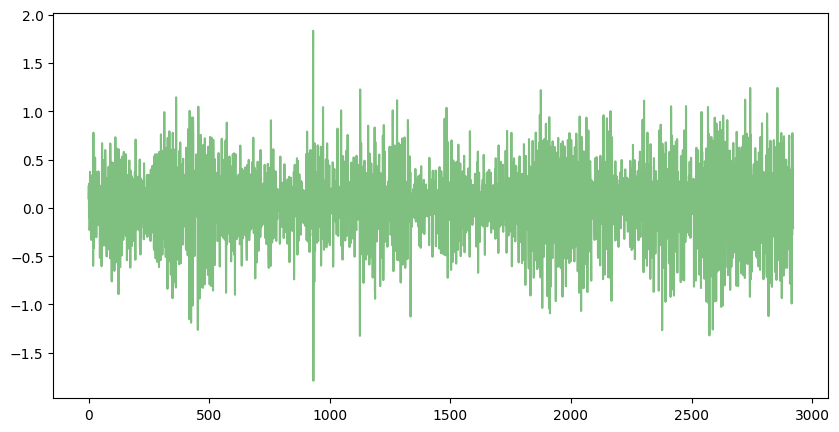

In [ ]:
plt.figure(figsize=(10, 5))
crop = 'Rice'
raw_price_pred = True
mape_metric = False
for price_lag in [2]:
  price_lag_scores = dict()
  for embedding_type in all_embeddings_dict:
    event_lag_r2scores = dict()
    for lag_id, lag in enumerate(event_lags):
      mean, scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, lag, not raw_price_pred)
      all_data = pd.concat([all_price_data, embed_multiplier*all_event_data], axis=1)
      all_data_agg = pd.concat([all_price_data, all_event_data_agg], axis=1)
      train_Y = np.ravel(diff_prices_scaled.loc[train_period_start+price_lag-1+n_step_ahead:train_period_end])
      test_y = np.ravel(diff_prices_scaled.loc[train_period_end+1:test_period_end])
      if lag == 1 and embedding_type == 'LDA':
        ar_residuals_train, ar_residuals_test, ar_test_rmse = ar_forecasts(all_price_data, crop, mean, scale, price_lag, train_Y, test_y, lag_id, mape=mape_metric)
      event_lag_r2scores[lag] = arx_forecasts(all_data_agg, crop, mean, scale, price_lag, train_Y, test_y, lag_id+1, mape=mape_metric)
      # event_lag_r2scores[lag] = arx_forecasts(all_event_data_agg, crop, scale, price_lag, ar_residuals_train, ar_residuals_test, lag_id+1)
    # find the best event lag
    best_event_lag = max(event_lag_r2scores, key=lambda w: event_lag_r2scores[w][0])
    price_lag_scores[embedding_type] = event_lag_r2scores[best_event_lag][1]
    if embedding_type == 'events':
      np.save(f'{path}earima_{crop}.npy', event_lag_r2scores[best_event_lag][2])
    # print(f"AR-{price_lag}+{embedding_type} w/ reg test RMSE for {crop} = {event_lag_r2scores[best_event_lag][1]}")
  print(f"{ar_test_rmse} {price_lag_scores['events']} {price_lag_scores['LDA']} {price_lag_scores['w2v']} {price_lag_scores['d2v']}")
#plt.legend(loc='best')

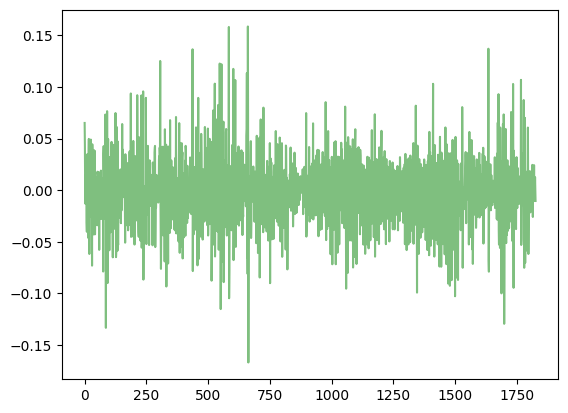

In [ ]:
crop = 'Wheat'
embedding_type = 'events'
price_lag = 1
scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
train_Y = np.ravel(diff_prices_scaled.loc[train_period_start+price_lag-1+n_step_ahead:train_period_end])
test_y = np.ravel(diff_prices_scaled.loc[train_period_end+1:test_period_end])
ar_residuals_train, ar_residuals_test, ar_test_rmse = ar_forecasts(all_price_data, crop, scale, price_lag, train_Y, test_y, 0)

Ridge regularization sensitivity

1 price    0.60364
dtype: float64 price   -0.615869
dtype: float64


test RMSE for AR-2 = 204.6382571425656
AR-2+events test RMSE for Onion = 0.1067
test RMSE for AR-2+X = 204.48832516555197
Test RMSE for 0.0001 = 0.1064 Coef sum = 110.99826786171519
test RMSE for AR-2+X = 204.39324782825918
Test RMSE for 0.0005 = 0.1062 Coef sum = 62.234086848242825
test RMSE for AR-2+X = 204.3187034652179
Test RMSE for 0.001 = 0.1062 Coef sum = 46.213340230719965
test RMSE for AR-2+X = 204.0988692710564
Test RMSE for 0.005 = 0.1061 Coef sum = 21.560757595732024
test RMSE for AR-2+X = 204.05352287987273
Test RMSE for 0.01 = 0.1060 Coef sum = 15.477345200601754
test RMSE for AR-2+X = 204.09439150614043
Test RMSE for 0.025 = 0.1061 Coef sum = 10.221712941472488
test RMSE for AR-2+X = 204.19960327714145
Test RMSE for 0.05 = 0.1061 Coef sum = 7.608634661245899
test RMSE for AR-2+X = 204.29220109639402
Test RMSE for 0.075 = 0.1062 Coef sum = 6.420344227063216
test RMSE for AR-2+X = 204.37681234228782
Test RMSE for 0.1 = 0.1062 Coef sum = 5.684648621972016
test RMSE for AR-2

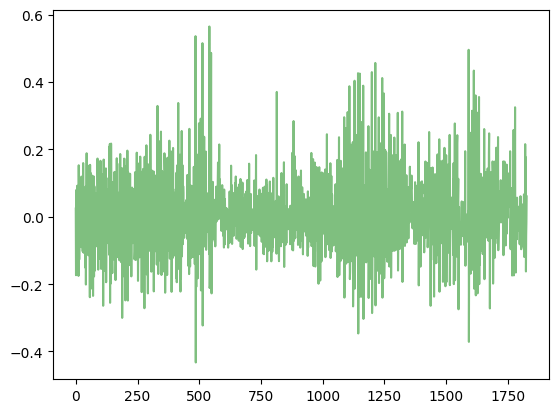

In [ ]:
crop = 'Onion'
embedding_type = 'events'
price_lag = 2
scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
predict_residuals = False
train_Y = np.ravel(diff_prices_scaled.loc[train_period_start+price_lag-1+n_step_ahead:train_period_end])
all_data_agg = pd.concat([all_price_data, all_event_data_agg], axis=1)
test_y = np.ravel(diff_prices_scaled.loc[train_period_end+1:test_period_end])
ar_residuals_train, ar_residuals_test, ar_rmse_test = ar_forecasts(all_price_data, crop, scale, price_lag, train_Y, test_y, 0)
if predict_residuals:
  test_y = ar_residuals_test
  train_Y = ar_residuals_train
  train_X = all_event_data_agg.loc[train_period_start+price_lag-1:train_period_end-n_step_ahead] # ignore first p rows since we do not have past y values
  test_X = all_event_data_agg.loc[train_period_end+1-n_step_ahead:test_period_end-n_step_ahead]
else:
  train_X = all_data_agg.loc[train_period_start+price_lag-1:train_period_end-n_step_ahead] # ignore first p rows since we do not have past y values
  test_X = all_data_agg.loc[train_period_end+1-n_step_ahead:test_period_end-n_step_ahead]
#ols_model = LinearRegression(fit_intercept=fit_intercept).fit(train_X, train_Y)
print(f"AR-{price_lag}+{embedding_type} test RMSE for {crop} = {ar_rmse_test:.4f}")
for alpha in reg_alphas_log_return:
  ridge_model = Ridge(alpha=alpha, fit_intercept=fit_intercept, max_iter=5000)
  ridge_model = ridge_model.fit(train_X, train_Y)
  # print(f'Train RMSE for {alpha} = {mean_squared_error(train_Y, lasso_model.predict(train_X), squared=False):.3f} Coef sum = {np.abs(lasso_model.coef_[p:]).sum()}')
  compute_rmse_for_price_pred_from_return_pred(ridge_model.predict(test_X), np.ravel(crop_prices_dict[crop].loc[train_period_end:].values), f'AR-{price_lag}+X')
  print(f'Test RMSE for {alpha} = {scale*mean_squared_error(test_y, ridge_model.predict(test_X), squared=False):.4f} Coef sum = {np.abs(ridge_model.coef_[price_lag:]).sum()}')

# Naive forecast


In [ ]:
def naive_forecasts(price_df, crop):
  true_prices_test = price_df.loc[train_period_end+1:test_period_end]
  predictions_test = price_df.loc[train_period_end+1-n_step_ahead:test_period_end-n_step_ahead]
  true_prices_train = price_df.loc[train_period_start+p-1+n_step_ahead:train_period_end]
  predictions_train = price_df.loc[train_period_start+p-1:train_period_end-n_step_ahead]
  print(f"Naive test RMSE and MAPE for {crop} = {mean_squared_error(true_prices_test, predictions_test, squared=False):.2f} and {mean_absolute_percentage_error(true_prices_test, predictions_test):.4f}")
  # print(f"Naive train RMSE for {crop} = {mean_squared_error(true_prices_train, predictions_train, squared=False):.2f}")
  #print(f"Test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

# Onion price forecast
naive_forecasts(df_o, 'Onion')
# Potato price forecast
naive_forecasts(df_p, 'Potato')
# Rice price forecast
naive_forecasts(df_r, 'Rice')
# Wheat price forecast
naive_forecasts(df_w, 'Wheat')

Naive test RMSE and MAPE for Onion = 188.22 and 0.0622
Naive test RMSE and MAPE for Potato = 107.00 and 0.0635
Naive test RMSE and MAPE for Rice = 178.81 and 0.0429
Naive test RMSE and MAPE for Wheat = 65.56 and 0.0257


In [ ]:
def naive_forecasts_for_log_returns(log_return_df, crop):
  true_returns_test = log_return_df.loc[train_period_end+1:test_period_end]
  print(f"Naive test RMSE for {crop} = {mean_squared_error(true_returns_test, np.zeros_like(true_returns_test), squared=False):.4f}")
  # print(f"Naive train RMSE for {crop} = {mean_squared_error(true_prices_train, predictions_train, squared=False):.2f}")
  #print(f"Test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

# Onion price forecast
naive_forecasts_for_log_returns(np.log(df_o).diff(), 'Onion')
# Potato price forecast
naive_forecasts_for_log_returns(np.log(df_p).diff(), 'Potato')
# Rice price forecast
naive_forecasts_for_log_returns(np.log(df_r).diff(), 'Rice')
# Wheat price forecast
naive_forecasts_for_log_returns(np.log(df_w).diff(), 'Wheat')

Naive test RMSE for Onion = 0.1203
Naive test RMSE for Potato = 0.1146
Naive test RMSE for Rice = 0.0594
Naive test RMSE for Wheat = 0.0360


In [ ]:
np.log(df_w).diff().max()

price    0.295576
dtype: float64

#### Test non-linear models

In [ ]:
def addSpanLag(data, events=[], look_back=7, look_ahead = 7, season=0):##span==1
#     ### Adding span (required for weekly, monthly average data)
#     if span>1:
#         nts = []
#         ind = 0
#         while ind < len(ts):
#             tmpts = ts[ind:ind+span]
#             print (tmpts)
#             dt = tmpts[0]
#             vals = [k for k in tmpts]
#             pr = sum(vals)/len(vals)
#             nts.append((dt,pr))
#             ind+=span
#         ts = nts
#     if not convert_to_Xy:
#         return ts

    ### Adding lag (based on look back and look ahead)

    if len(events) > 0:
        input = np.append(data,events,axis=1)
    else:
        input = data

    if season>0:
        season = np.array([k%season for k in range(data.shape[0])])
        season = season.reshape(len(season),1)
        input = np.append(input,season,axis=1)

    ind = 0
    X_data = []
    y_data = []

    while ind + look_back + look_ahead < len(data):

        X = input[ind:ind+look_back]
        Y = data[ind+look_back+look_ahead]
        X_data.append(X)
        y_data.append(Y)
        ind+=1
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

In [ ]:
crop = 'Wheat'
price_lag = 7
embedding_type = 'events'
scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
X_lstm, y_lstm = addSpanLag(diff_prices_scaled.iloc[1:].values, look_back=7,look_ahead=0)

In [ ]:
num_test_preds = y_lstm[num_train_days-1:].shape[0]
num_test_preds

2915

In [ ]:
crop_prices_dict[crop].iloc[-num_test_preds-1:].shape

(2916, 1)

In [ ]:
models_path = '/content/drive/MyDrive/news-based-forecasting/models/onedayahead_logreturn/'
crop = 'Onion'
price_lag = 7
embedding_type = 'events'
mean, scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
X_event, y_event = addSpanLag(diff_prices_scaled.iloc[1:].values, all_embeddings_dict[embedding_type].values[1:], look_back=price_lag, look_ahead=0)
X_lstm, y_lstm = addSpanLag(diff_prices_scaled.iloc[1:].values, look_back=price_lag,look_ahead=0)
num_test_preds = y_lstm[num_train_days-1:].shape[0]
model_name = f'lstm_{crop}'
model = keras.models.load_model(os.path.join(models_path,model_name))
np.save(f'{path}true_{crop}_returns.npy', y_lstm[num_train_days-1:])
compute_errors_for_price_pred_from_return_pred(model.predict(X_lstm[num_train_days-1:]), crop_prices_dict[crop].iloc[-num_test_preds-1:].values, model_name)
compute_errors_for_price_pred_from_return_pred(model.predict(X_lstm[:num_train_days-1]), crop_prices_dict[crop].iloc[price_lag:price_lag+num_train_days].values, model_name, False)

#print(f"lstm train RMSE for {crop} = {mean_squared_error(y_lstm[:num_train_days-1], model.predict(X_lstm[:num_train_days-1]), squared=False)}")
#print(f"lstm test RMSE for {crop} = {np.sqrt(model.evaluate(X_lstm[num_train_days-1:], y_lstm[num_train_days-1:]))}")
  #model_name = f'{model_type}_crop={crop}_norm=True_season=0'
model_name = f'ren_{crop}'
model = keras.models.load_model(os.path.join(models_path,model_name))
compute_errors_for_price_pred_from_return_pred(model.predict(X_event[num_train_days-1:]), crop_prices_dict[crop].iloc[-num_test_preds-1:].values, model_name)
compute_errors_for_price_pred_from_return_pred(model.predict(X_event[:num_train_days-1]), crop_prices_dict[crop].iloc[price_lag:price_lag+num_train_days].values, model_name, False)
#print(f"{embedding_type} train RMSE for {crop} = {mean_squared_error(y_event[:num_train_days-1], model.predict(X_event[:num_train_days-1]), squared=False)}")

embedding_type = 'LDA'
mean, scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
X_event, y_event = addSpanLag(diff_prices_scaled.iloc[1:].values, all_embeddings_dict[embedding_type].values[1:], look_back=price_lag, look_ahead=0)
model_name = f'lda_{crop}'
model = keras.models.load_model(os.path.join(models_path,model_name))
compute_errors_for_price_pred_from_return_pred(model.predict(X_event[num_train_days-1:]), crop_prices_dict[crop].iloc[-num_test_preds-1:].values, model_name)
#print(f"{embedding_type} test RMSE for {crop} = {mean_squared_error(y_event[num_train_days-1:], model.predict(X_event[num_train_days-1:]), squared=False)}")

embedding_type = 'w2v'
mean, scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
X_event, y_event = addSpanLag(diff_prices_scaled.iloc[1:].values, all_embeddings_dict[embedding_type].values[1:], look_back=price_lag, look_ahead=0)
model_name = f'w2v_{crop}'
model = keras.models.load_model(os.path.join(models_path,model_name))
compute_errors_for_price_pred_from_return_pred(model.predict(X_event[num_train_days-1:]), crop_prices_dict[crop].iloc[-num_test_preds-1:].values, model_name)
#print(f"{embedding_type} test RMSE for {crop} = {mean_squared_error(y_event[num_train_days-1:], model.predict(X_event[num_train_days-1:]), squared=False)}")

embedding_type = 'd2v'
mean, scale, all_event_data_agg, all_event_data, all_price_data, diff_prices_scaled = prepare_data(crop, embedding_type, price_lag, 7, True)
X_event, y_event = addSpanLag(diff_prices_scaled.iloc[1:].values, all_embeddings_dict[embedding_type].values[1:], look_back=price_lag, look_ahead=0)
model_name = f'd2v_{crop}'
model = keras.models.load_model(os.path.join(models_path,model_name))
compute_errors_for_price_pred_from_return_pred(model.predict(X_event[num_train_days-1:]), crop_prices_dict[crop].iloc[-num_test_preds-1:].values, model_name)
#print(f"{embedding_type} test RMSE for {crop} = {mean_squared_error(y_event[num_train_days-1:], model.predict(X_event[num_train_days-1:]), squared=False)}")
# print(f"ren test RMSE for {crop} = {np.sqrt(model.evaluate(X_event[num_train_days-1:], y_event[num_train_days-1:]))}")
# print(f"{model_type} test RMSE for {crop} = {diff_prices.std()*np.sqrt(model.evaluate(X_event[num_train_days:], y_event[num_train_days:]))}")


92/92 [==============================] - 1s 5ms/step
RMSE and MAPE for lstm_Onion = 167.72 0.0568
80/80 [==============================] - 0s 4ms/step
RMSE and MAPE for lstm_Onion = 38.91 0.0282
92/92 [==============================] - 2s 10ms/step
RMSE and MAPE for ren_Onion = 155.56 0.0520
80/80 [==============================] - 1s 9ms/step
RMSE and MAPE for ren_Onion = 39.31 0.0270
92/92 [==============================] - 0s 2ms/step
RMSE and MAPE for lda_Onion = 188.34 0.0622
92/92 [==============================] - 0s 2ms/step
RMSE and MAPE for w2v_Onion = 189.53 0.0632
92/92 [==============================] - 0s 2ms/step
RMSE and MAPE for d2v_Onion = 189.56 0.0632


In [ ]:
a = model.predict(X_lstm[num_train_days-1:])

92/92 [==============================] - 0s 3ms/step


In [ ]:
X_event[0]

array([[ 4.02530738e-02,  0.00000000e+00,  1.15179735e-01, ...,
         0.00000000e+00,  1.98480793e-02,  0.00000000e+00],
       [ 2.20043706e-02,  0.00000000e+00,  1.66838221e-01, ...,
         4.96028839e-05,  5.27946826e-03,  2.38087518e-02],
       [-4.99314822e-02,  0.00000000e+00,  5.19766594e-02, ...,
         8.62208269e-05,  1.60647447e-03,  0.00000000e+00],
       ...,
       [ 4.11220189e-03,  0.00000000e+00,  9.84777684e-02, ...,
         0.00000000e+00,  2.89949314e-04,  2.11557609e-02],
       [-4.98340151e-02,  0.00000000e+00,  1.28891888e-01, ...,
         3.42959550e-03,  1.08462544e-02,  1.62346850e-03],
       [-3.72375859e-02,  0.00000000e+00,  5.36293819e-02, ...,
         2.14726614e-04,  1.31565933e-03,  1.63875025e-05]])

In [ ]:
all_price_data.iloc[num_train_days+price_lag]

0   -0.030350
1    0.118877
2   -0.123274
3    0.006715
4   -0.026179
5    0.014393
6   -0.016897
Name: 2013-01-08 00:00:00, dtype: float64

LASSO regularization sensitivity



In [ ]:
train_X = all_data.loc[train_period_start+p-1:train_period_end-n_step_ahead] # ignore first p rows since we do not have past y values
train_Y = np.ravel(diff_prices_scaled.loc[train_period_start+p-1+n_step_ahead:train_period_end])
test_X = all_data.loc[train_period_end+1-n_step_ahead:test_period_end-n_step_ahead]
for alpha in reg_alphas:
  lasso_model = LassoLars(alpha=alpha, fit_intercept=fit_intercept, max_iter=5000)
  lasso_model = lasso_model.fit(train_X, train_Y)
  # lasso_model = LassoCV(cv=TimeSeriesSplit(), random_state=0, fit_intercept=fit_intercept, alphas=reg_alphas, max_iter=5000).fit(train_X, train_Y)
  # print(f'Train RMSE for {alpha} = {mean_squared_error(train_Y, lasso_model.predict(train_X), squared=False):.3f} Coef sum = {np.abs(lasso_model.coef_[p:]).sum()}')
  print(f'Test RMSE for {alpha} = {scale*mean_squared_error(test_y, lasso_model.predict(test_X), squared=False)} Coef sum = {np.abs(lasso_model.coef_[p:]).sum()}')

Test RMSE for 1e-05 = [333.54165445] Coef sum = 149.55783965230694
Test RMSE for 2e-05 = [305.92758162] Coef sum = 90.33659909843561
Test RMSE for 3e-05 = [295.67650088] Coef sum = 67.44506239539453
Test RMSE for 4e-05 = [291.96578036] Coef sum = 57.6437407846416
Test RMSE for 5e-05 = [290.30227351] Coef sum = 51.20371804188376
Test RMSE for 6e-05 = [289.14177953] Coef sum = 46.67722181870964
Test RMSE for 7e-05 = [288.00471558] Coef sum = 42.83865255200074
Test RMSE for 8e-05 = [287.00472098] Coef sum = 39.7221352381267
Test RMSE for 9e-05 = [286.21224689] Coef sum = 36.99181964543802
Test RMSE for 0.0001 = [285.49609096] Coef sum = 34.62527522310612
Test RMSE for 0.0002 = [281.48469159] Coef sum = 19.500888324351664
Test RMSE for 0.0003 = [280.45701123] Coef sum = 11.968013871693177
Test RMSE for 0.0004 = [280.86694232] Coef sum = 7.557958150247405
Test RMSE for 0.0005 = [281.85555628] Coef sum = 4.8130175806864655
Test RMSE for 0.0006 = [282.78454869] Coef sum = 3.1388393255886946
T

In [ ]:
all_data_agg.shape

(5479, 257)

Use emebddings to explain ARIMA residuals

In [ ]:
train_X = all_event_data.loc[train_period_start+p-1:train_period_end-1] # ignore first p rows since we do not have past y values
train_Y = arima_residuals_train
ols_model = LinearRegression(fit_intercept=fit_intercept).fit(train_X, train_Y)
print(ols_model.coef_[:p])
lasso_model = LassoCV(cv=TimeSeriesSplit(), random_state=0, fit_intercept=fit_intercept, alphas=reg_alphas).fit(train_X, train_Y)
print(lasso_model.coef_)
ridge_model = RidgeCV(alphas=reg_alphas, cv=TimeSeriesSplit(), fit_intercept=fit_intercept).fit(train_X, train_Y)
test_X = all_event_data.loc[train_period_end:test_period_end-1]
test_y = arima_residuals_test
print(f"AR-{p}+{embedding_type} train RMSE for {crop} = {mean_squared_error(train_Y, ols_model.predict(train_X), squared=False):.2f}")
print(f"AR-{p}+{embedding_type} with diff test RMSE for {crop} = {mean_squared_error(test_y, ols_model.predict(test_X), squared=False):.3f}")
print(f"AR-{p}+{embedding_type} with diff test RMSE for {crop} = {mean_squared_error(test_y, lasso_model.predict(test_X), squared=False):.3f}")
print(f"AR-{p}+{embedding_type} with diff test RMSE for {crop} = {mean_squared_error(test_y, ridge_model.predict(test_X), squared=False):.3f}")

[-0.49516666 -0.52263173  0.90556817 -0.025921   -0.13466711  0.15836618
  0.11833302]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.033209308872102, tolerance: 0.02519775498483332
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.9652539149341, tolerance: 0.02519775498483332
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.17418067299039, tolerance: 0.02519775498483332
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergen

[-0.  0.  0. -0. -0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0. -0. -0.
 -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
 -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0.
 -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0.  0.
 -0. -0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0.  0.
 -0.  0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.
  0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0. -0.  0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0

In [ ]:
max_abs_scaler.mean_

array([0.28999432])

In [ ]:
max_abs_scaler.inverse_transform(np.atleast_2d(0.1))

array([[5.81359141]])

In [ ]:
train_X = all_data.iloc[:num_train_days-1] # ignore first row since we do not have past y values
ols_model = OLS(train_y, train_X).fit()
test_X = all_data.iloc[num_train_days-1:test_period_end-1]
test_y = all_data.iloc[num_train_days+n_step_ahead-1:test_period_end, 0]
print(f"AR-{p}+{embedding_type} with diff train RMSE for {crop} = {mean_squared_error(train_y, ols_model.fittedvalues, squared=False):.2f}")
print(f"AR-{p}+{embedding_type} with diff test RMSE for {crop} = {mean_squared_error(test_y, ols_model.predict(test_X), squared=False):.2f}")

In [ ]:
ols_model.fittedvalues

date
2006-01-02    -3.685548
2006-01-03     1.888242
2006-01-04    -4.923638
2006-01-05    -5.183737
2006-01-06   -29.585981
                ...    
2012-12-27   -26.890954
2012-12-28   -29.758232
2012-12-29     1.938432
2012-12-30    61.419653
2012-12-31   -35.817869
Freq: D, Length: 2556, dtype: float64

In [ ]:
diff_prices = df_o.diff()
ar_prices_train = diff_prices.iloc[1:num_train_days] # ignore the first day
ar_prices_test = diff_prices.iloc[num_train_days:]

In [ ]:
ar_model = AutoReg(ar_prices_train, lags=p, trend='n')
ar_model_fit = ar_model.fit()
ar_params = ar_model_fit.params
#model_fit = model.fit(maxiter=200)
print(f"AR-{p} with diff train RMSE for Onion = {mean_squared_error(ar_prices_train, model_fit.predict(), squared=False):.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
ar_model_fit.params

price.L1   -0.149024
price.L2    0.030231
price.L3    0.082662
price.L4    0.083001
price.L5    0.010617
price.L6    0.023143
price.L7    0.278307
dtype: float64

In [ ]:
arx_model = AutoReg(ar_prices, lags=p, trend='n', exog=train_event_embeddings[1:])
arx_model_fit = arx_model.fit()
arx_params = arx_model_fit.params

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
arx_model_fit.predict()

2006-01-02         NaN
2006-01-03         NaN
2006-01-04         NaN
2006-01-05         NaN
2006-01-06         NaN
                ...   
2012-12-27   -0.023135
2012-12-28   -0.091455
2012-12-29   -0.061538
2012-12-30   -0.130683
2012-12-31    0.295967
Freq: D, Length: 2556, dtype: float64

In [ ]:
earima_model = ARIMA(df_train, exog=train_event_embeddings, order=(p,d,q))
earima_model_fit = earima_model.fit(method_kwargs={'maxiter': 200})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
earima_model_fit.params['x1']

1812.0195223619269

In [ ]:
data_length = 2915
print(mean_squared_error(df_o.iloc[num_train_days:num_train_days+data_length], model_fit.predict(start=num_train_days, end=num_train_days+data_length-1), squared=False))

1159.4247423168952


In [ ]:
earima_model_fit.predict()

2006-01-01    48.617878
2006-01-02     6.601795
2006-01-03     6.332597
2006-01-04     6.356331
2006-01-05     6.411314
                ...    
2012-12-27    13.096935
2012-12-28    13.388280
2012-12-29    13.065289
2012-12-30    12.812405
2012-12-31    12.866016
Freq: D, Name: predicted_mean, Length: 2557, dtype: float64